# Ford GoBike System Data Exploration

Ford GoBike data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. Data contains information about Trips, Stations, Bikes and Users. 


In [73]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

#----------------------------------------------------------------------------------
# helper methods
from IPython.core.display import display, HTML
from base64 import b64encode
from io import BytesIO
from math import sin, cos, sqrt, atan2, radians
import uuid

#select color palette
color_palette = sb.color_palette()[0]
import warnings
warnings.filterwarnings("ignore")

#----------------------------------------------------------------------------------------------------------
def new_figId():
    return str(uuid.uuid4())
#----------------------------------------------------------------------------------------------------------
def visualize(*items, **kwargs):
    
    options = {'title':None, 'df_titles' : [], 'df_titles_color' : 'black', 'df_titles_font_size' : '14px'}
    options.update(kwargs)
    
    title = options['title'] if options['title'] != None else ''
    table_height, df_count = 'auto', -1
    data = f'<div style="text-align: center;"><span style="text-align: center;font-weight: bold;">{title}</span></div>'
    
    for item in items:
        #print(item)
        
        if isinstance(item, str):
            item = f'<span style="color:blue">{item}</span>'
            #table_height = '95%'
            
        elif isinstance(item, pd.DataFrame):
            df_count += 1
            caption = str(options['df_titles'][df_count]) if(len(options['df_titles'])>df_count) else '' 
            item = (item.style.set_table_attributes("style='display:inline;margin-right:20px;'")
                             .set_caption(caption)
                             .set_table_styles([{'selector': 'caption',
                                                 'props': [('color', options['df_titles_color']),
                                                           ('font-size', options['df_titles_font_size'])]}])
                             ._repr_html_() + "\xa0\xa0\xa0")
        
        elif('AxesSubplot' in str(type(item)) or type(item)==plt.Figure):
            item = item.get_figure() if type(item)!=plt.Figure else item
            figdata = BytesIO()  #plt.tight_layout()
            item.savefig(figdata, format='png', bbox_inches = "tight")
            #item.legends = []
            plt.close()
            item =  f'<img src="data:image/png;base64,{b64encode(figdata.getvalue()).decode()}"/>'
            
        elif("seaborn.axisgrid" in str(type(item))):
            item = item.fig #if type(item)!=plt.Figure else item
            figdata = BytesIO()  #plt.tight_layout()
            item.savefig(figdata, format='png', bbox_inches = "tight")
            #item.legends = []
            plt.close()            
            item =  f'<img src="data:image/png;base64,{b64encode(figdata.getvalue()).decode()}"/>'
            
        data += (f"""<table style="display:inline-block; height:{table_height}">
                        <tr style="background-color: transparent;vertical-align: top;">
                            <td style="background-color: transparent;vertical-align: top;text-align: left;">{item}</td>
                        </tr>
                    </table>""")  
    display(HTML(str("<style>div.output_scroll { height: auto;  }</style>")))
    display(HTML(data))     
#---------------------------------------------------------------------------------------------------------------
def set_countplot_percentage(feature, ax, label_hight_offset = 1):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height() + (label_hight_offset * 1000) 
        ax.annotate(percentage, (x, y), ha='center')
#--------------------------------------------------------------------------------------------------------------- 

In [74]:
# load in the dataset into a pandas dataframe
df_org = pd.read_csv('201902-fordgobike-tripdata.csv')
df = df_org.copy()
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [75]:
df['member_age'] = 2019-df['member_birth_year']

In [76]:
print(f'{df.member_age.isnull().sum()} null member ages to be dropped')
df = df[df.member_age.notnull()]

#convery member_age to int
df.member_age = df.member_age.astype('int')
df.duration_min = df.member_age.astype('float')

8265 null member ages to be dropped


In [77]:
# convert start and end time to datetime format 
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

# determine if trip is at day or night time
df['trip_day_night'] = pd.to_datetime(df.start_time, unit='s').apply(lambda x: "Day" if x.hour >= 6 and x.hour <= 18 else "Night")
# determine day name for each trip based on trip start_time
df['trip_day'] = df.start_time.dt.day_name()
# determine trip duration in min from duration in sec 
df['duration_min'] = round(df.duration_sec/60,0)
# determine start hour
df['start_hour']= df['start_time'].dt.hour


In [78]:
# Convert to categoral.
gender = list(df.member_gender.value_counts().index)
gender = pd.api.types.CategoricalDtype(ordered = True, categories = gender)
df.member_gender = df.member_gender.astype(gender)

day = list(df.trip_day.value_counts().index)
day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day = pd.api.types.CategoricalDtype(ordered = True, categories = day)
df.trip_day = df.trip_day.astype(day)


In [79]:
#drop non-useful columns after cleaning 

df.drop(['start_time', 'end_time','duration_sec','member_birth_year', 
         'bike_id', 'start_station_name', 'end_station_name', 
         'bike_share_for_all_trip', 'start_station_latitude', 'start_station_longitude', 
         'end_station_latitude', 'end_station_longitude'], axis=1, inplace=True, errors='ignore')
df.head()

,start_station_id,end_station_id,user_type,member_gender,member_age,trip_day_night,trip_day,duration_min,start_hour
0,21.0,13.0,Customer,Male,35,Day,Thursday,870.0,17
2,86.0,3.0,Customer,Male,47,Day,Thursday,1031.0,12
3,375.0,70.0,Subscriber,Other,30,Day,Thursday,608.0,17
4,7.0,222.0,Subscriber,Male,45,Night,Thursday,26.0,23
5,93.0,323.0,Subscriber,Male,60,Night,Thursday,30.0,23


## Dataset overview

The original dataset contains 183,412 trip. Features are realated to trip, statation, bike and user as following: 

* Trip (duration, start & end time)
* Station (start & end station id, name, geographic coordinates)
* Bike id 
* User (Customer or subscriber, gender, birth year)

After wrangling the data, only 175,147 trip will be considered in the analysis. New features have been extraction to the support the analysis, as following: 

* Trip start hour
* Trip duration in minutes 
* Member age 
* Trip was at daylight or night


## Distribution of Trip duration 

Trip duration in the dataset ranges from 1 min to 18 hours. Plotted on a logarithmic scale, the distribution of diamond prices takes on a unimodal shape, with average trip duration of approximately 11 min, and most trips took 5 to 15 min. 

""

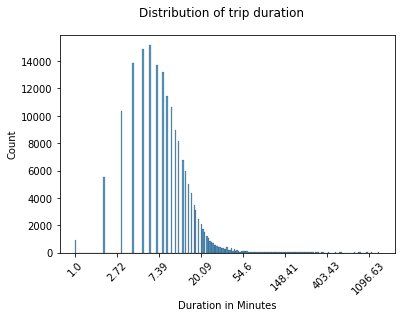

In [80]:
## there's a long tail in the distribution, so let's put it on a log scale instead

# create log_duration_min in the dataframe to use it 
df['log_duration_min']= df['duration_min'].apply(np.log)

plt.figure(new_figId()).suptitle('Distribution of trip duration')
hst= sb.histplot(data = df, x = 'log_duration_min');
hst.set_xticklabels([round(np.exp(i),2) for i in plt.xticks()[0]], rotation=45);
hst.set(xlabel='Duration in Minutes', ylabel='Count')



visualize(hst);

## Distribution of Member ages

The distribution of age shows that 99.5% of the trips took place by members under 70. Most member ages are between 27 and 39, full range of ages from 18 to 67, and average age is 34.


""

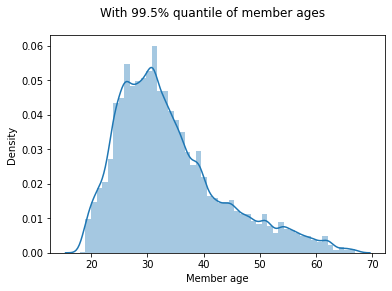

In [81]:

# visualize 99.5% quantile of member ages
dst_995 = plt.figure(new_figId()) 
dst_995.suptitle('With 99.5% quantile of member ages')
sb.distplot(df[df.member_age < df.member_age.quantile(.995)].member_age).set(xlabel='Member age');

visualize(  dst_995 )


In [82]:
# select trips by member ages < 70 and check if there are any nulls afterwards 
df = df[df.member_age < 70]
df.member_age.isnull().sum()

0

## Distribution of User Gender and Type


Trips by Males are around 75%, 24% by Females and 2% by Other. Also, Trips by Subscriber are around 90% and 10% by Customer.

""
""

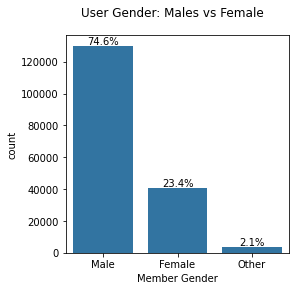
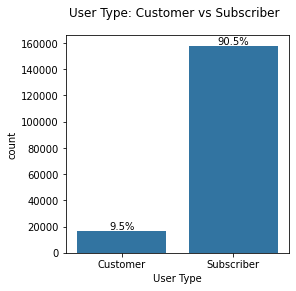

In [83]:
gender_fig = plt.figure(new_figId(),figsize=(4,4));
gender_fig.suptitle('User Gender: Males vs Female ')
ax = sb.countplot(data= df, x= 'member_gender', color = color_palette);
ax.set(xlabel='Member Gender')
set_countplot_percentage(df['user_type'], ax)

day_night_fig = plt.figure(new_figId(),figsize=(4,4));
day_night_fig.suptitle('User Type: Customer vs Subscriber')
ax = sb.countplot(data= df, x= 'user_type', color = color_palette);
ax.set(xlabel='User Type')
set_countplot_percentage(df['user_type'], ax)
        
visualize(gender_fig, day_night_fig)


## Trips count for Gender and User Type every day of the week  

Trip counts varies with day of week, where week days trip counts are much more than trips in week ends. Male trips are more than female, Subscriber trips are more that Customer.

""
""

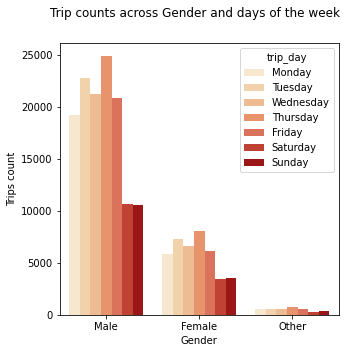
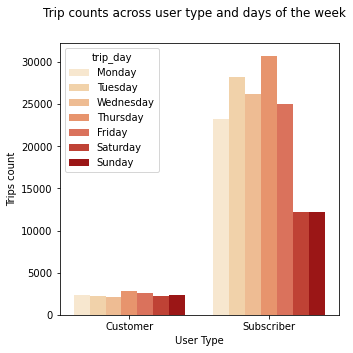

In [84]:
plt.figure(new_figId(), figsize=(5,5)).suptitle('Trip counts across Gender and days of the week')
mg_td= sb.countplot(data= df, x= 'member_gender', hue='trip_day', palette= 'OrRd')
mg_td.set(xlabel='Gender', ylabel='Trips count');

plt.figure(new_figId(), figsize=(5,5)).suptitle('Trip counts across user type and days of the week')
ut_td = sb.countplot(data= df, x= 'user_type', hue='trip_day', palette= 'OrRd')
ut_td.set(xlabel='User Type', ylabel='Trips count');

visualize(mg_td, ut_td)

## Trips count for Age group, Gender and User Type for every day of the week

The highest number of trips is taking place on working days by Male Subscribers of age between 26 and 35, followed by trips at the same times by Male Subscribers of age between 36 and 45

""

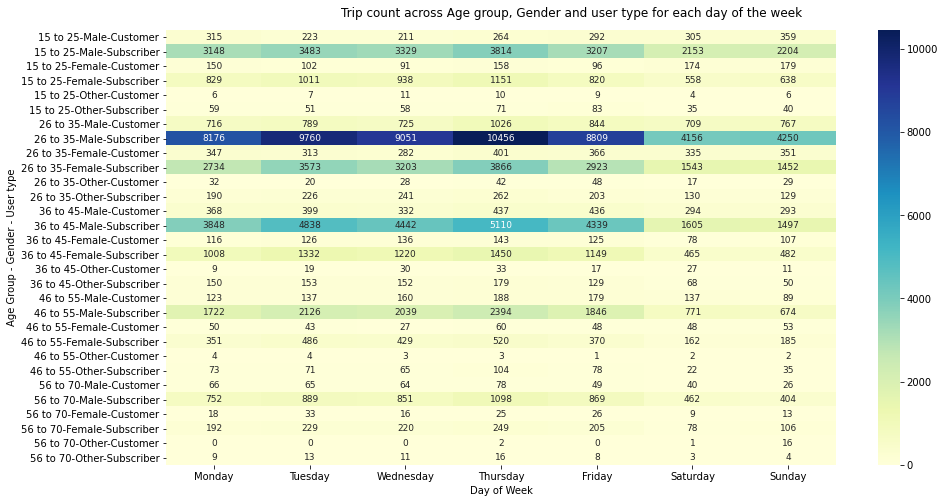

In [89]:
#calculate age groups from 15 to 70 years each group 10 years 

df['age_bins'] = pd.cut(x=df.member_age, bins=[15, 25, 35, 45, 55, 70],
                        labels=['15 to 25', '26 to 35', '36 to 45', '46 to 55', '56 to 70'])

ga = df.groupby(['age_bins', 'member_gender', 'user_type', 'trip_day'])['duration_min'].count().reset_index(name="count")
ga= ga.pivot_table(index=['age_bins', 'member_gender', 'user_type'], columns="trip_day", values='count', aggfunc = np.sum)

plt.figure(new_figId(), figsize=(15, 8)).suptitle('Trip count across Age group, Gender and user type for each day of the week', y=0.92)
#f4.suptitle('Number of trips for Age group vs. Gender vs. User type vs. Day of Week')
g = sb.heatmap(ga, fmt='d',  annot=True, cmap='YlGnBu', annot_kws={'size': 9})
g.set(xlabel='Day of Week', ylabel='Age Group - Gender - User type')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 10)
visualize(g)

## Visualizing disrtibution of Age/Gender vs Trip duration

Member of age from 24 to 32 are achieving duration around 13 min Distribution of male vs female is similar but duration by females and age of females are less that males

## Trip duration by Age group and User type/Gender 

The plot shows that males age groups are always achieving longer duration that females. Also, Others age groups are always achieving longer duration than males and females except for those who are between 56 to 70 years old. Finally, Customer age groups are making longer duration than subscribers

""
""

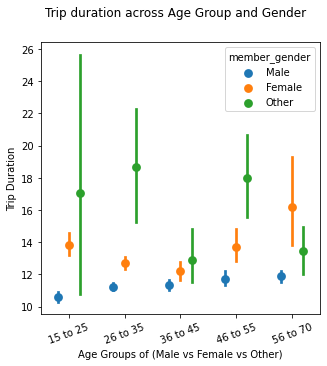
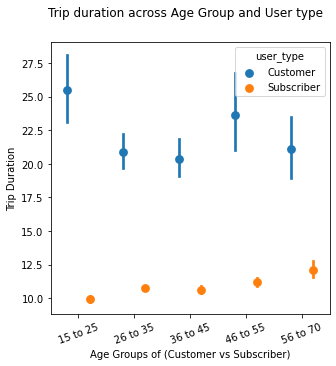

In [86]:
plt.figure(new_figId(), figsize=(5,5)).suptitle('Trip duration across Age Group and Gender')
d_g = sb.pointplot(data =df, x = 'age_bins', y = 'duration_min', hue = 'member_gender', linestyles = '', dodge = 0.4)
d_g.set(xlabel='Age Groups of (Male vs Female vs Other)', ylabel='Trip Duration')
d_g.set_xticklabels(labels= plt.xticks()[1], rotation=20)

plt.figure(new_figId(), figsize=(5,5)).suptitle('Trip duration across Age Group and User type')
d_ut = sb.pointplot(data =df, x = 'age_bins', y = 'duration_min', hue = 'user_type', linestyles = '', dodge = 0.4)
d_ut.set(xlabel='Age Groups of (Customer vs Subscriber)', ylabel='Trip Duration')
d_ut.set_xticklabels(labels= plt.xticks()[1], rotation=20)

visualize( d_g, d_ut)